# Precision-Recall
**Precision-Recall** is a useful measure of success of prediction when the classes are very imbalanced.

In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold

Precision-recall curves are typically used in binary classification to study the output of a classifier.

$Precision = \frac{TP}{TP + FP}$

$Recall = \frac{TP}{TP + FN}$

$F1 = 2 \cdot \frac{P \cdot R}{P + R}$

$AP=\sum_{n}^{}{(R_n - R_{n-1})\cdot P_n}$

## single class

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [2]:
X, y = load_iris(return_X_y=True)

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X[y < 2], y[y < 2], test_size=0.5, random_state=random_state
)

In [3]:
classifier = make_pipeline(StandardScaler(), LinearSVC(random_state=random_state))
classifier.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(random_state=RandomState(MT19937) at 0x16C7F7D40))])

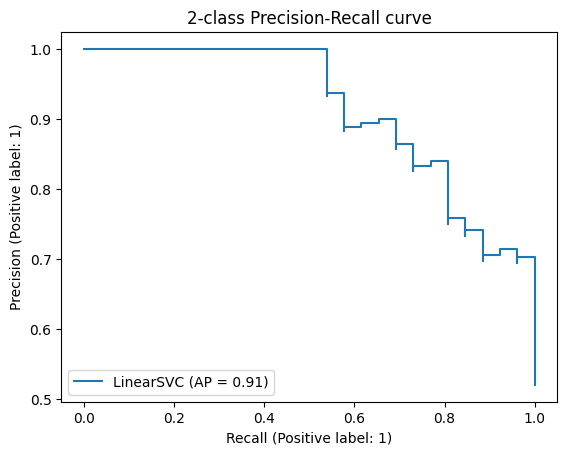

In [4]:
display = PrecisionRecallDisplay.from_estimator(
    classifier, X_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

## multi class

In [5]:
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=random_state
)

In [6]:
from sklearn.multiclass import OneVsRestClassifier

classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(), LinearSVC(random_state=random_state))
)
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

In [7]:
from sklearn.metrics import average_precision_score, precision_recall_curve

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

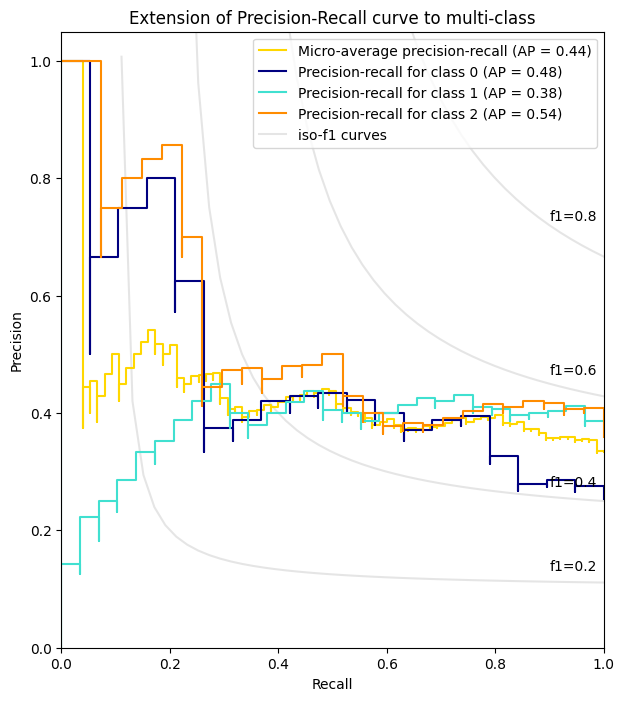

In [8]:
from itertools import cycle

import matplotlib.pyplot as plt

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

## ref
- [Sklearn Precision-Recall example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)